# Modern Portfolio Theory

Given a number of stocks, we simulate a number of portfolios, compute the efficient frontier, maximum Sharpe portfolio, minimum variance portfolio and capital market line.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sco

import datetime as dt
from dateutil.relativedelta import relativedelta

import yfinance as yf
import statsmodels.api as sm

The mathematical formulas involved in the mean-variance portfolio analysis are:

$P=\sum_i w_i R_i=w\cdot R$

$E(P)=\sum_i w_i E(R_i) = w\cdot E(R)$

$V(P)=\sum_i w_i^2 V(R_i) + \sum_{i\neq j}w_{i}w_{j}Cov(R_i,R_j)= w^T \Sigma\,w$

# Load data

In [2]:
stocks=yf.download("AAPL MSFT TSLA GOOG", period="1y", interval='1d')
stocks=stocks.Close

[*********************100%%**********************]  4 of 4 completed


/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecat

# Function definitions

### Auxiliary functions

In [3]:
def log_ret(prices):
    log_ret=np.log(prices/prices.shift(1))
    return log_ret


def gen_weights(num, short=True):
    weights=np.random.random(num)
    #if short==True:
    #    weights=weights-0.5
    #else:
    #    weights=weights
    weights=weights/weights.sum()
    return weights


def weights_to_pf(some_stocks, weights):
    weights=np.array(weights)/np.array(weights).sum()
    daily_log_returns=log_ret(some_stocks)
    ER=252*(daily_log_returns.mean())
    CovR=252*(daily_log_returns.cov())
    #ER=np.exp(ER)-1
    #CovR=np.exp(CovR)

    EP=np.dot(weights,ER)
    VP=np.dot(weights, np.dot(CovR, weights))
    sigmaP=np.sqrt(VP)

    return (EP, sigmaP)




def gen_pfs(data, rf, num_pfs):
    sharpes=[]
    exps=[]
    vols=[]
    weights_list=[]
    number_of_assets=len(data.columns)
    for i in range(num_pfs):
        weights=gen_weights(number_of_assets)
        pf=weights_to_pf(data, weights)
        sharpes.append((pf[0]-rf)/pf[1])
        exps.append(pf[0])
        vols.append(pf[1])
        weights_list.append(weights)
    results={}
    results['sharpes']=sharpes
    results['exps']=exps
    results['vols']=vols
    results['weights']=weights_list
    return results

### Main function: portfolio simulation

In [4]:
#MAIN PROGRAM: SIMULATION OF PORTFOLIOS

def simulation(data, rf, num_pfs):

    #add a riskfree asset to the data with annual return 'rf'
    #riskfree=pd.Series((1+np.log(rf+1)/252)*np.ones(len(data)),index=data.index,dtype=float).cumprod()
    #data['riskfree']=riskfree
    
### Generate the portfolios
    number_of_assets=len(data.columns)
    portfolios=gen_pfs(data,rf,num_pfs)
        
#########################################################

### Definition of objective functions to be optimized
  
    def sharpe(weights):
        e,sigma=weights_to_pf(data,weights)
        return (e-rf)/sigma

    def neg_sharpe(weights):
        return -sharpe(weights)
    
    def expected_vol(weights):
        return weights_to_pf(data,weights)[1]

    def expected_ret(weights):
        return weights_to_pf(data,weights)[0]


### Maximize sharpe ratio

    sum_to_one={'type':'eq', 'fun':lambda x: np.sum(x)-1}
    bounds=tuple((0,1) for x in range(number_of_assets))
    init_weights=np.ones(number_of_assets)*(1/number_of_assets)

    opt_sharpe_pf=sco.minimize(neg_sharpe, constraints=sum_to_one, bounds=bounds, x0=init_weights)
    
    opt_sharpe_weights=opt_sharpe_pf['x']
    opt_sharpe_exp=expected_ret(opt_sharpe_weights)
    opt_sharpe_vol=expected_vol(opt_sharpe_weights)
    opt_sharpe_sharpe=sharpe(opt_sharpe_weights)

### Minimize volatility
    
    opt_vol_pf=sco.minimize(expected_vol, constraints=sum_to_one, bounds=bounds, x0=init_weights)

    opt_vol_weights=opt_vol_pf['x']
    opt_vol_exp=expected_ret(opt_vol_weights)
    opt_vol_vol=expected_vol(opt_vol_weights)
    opt_vol_sharpe=sharpe(opt_vol_weights)
    
### Minimize volatility for a given return    
    

    ret_levels=np.linspace(opt_vol_exp,opt_sharpe_exp,20) 
    
    
    volatilities=[]
    for ret in ret_levels:
        fixed_return={'type':'eq', 'fun':lambda x: expected_ret(x)-ret}
        opt=sco.minimize(expected_vol, constraints=[sum_to_one,fixed_return], bounds=bounds, x0=init_weights)
        volatilities.append(opt['fun'])


########################################################################     
### RESULTS ############################################################                
        
    results={}
    results['portfolios']=portfolios
    
    results['max_sharpe_pf']={'weights':opt_sharpe_weights,\
                              'sharpe': opt_sharpe_sharpe,\
                              'exp': opt_sharpe_exp,\
                              'vol': opt_sharpe_vol}
                              
    results['min_vol_pf']={'weights':opt_vol_weights,\
                              'sharpe': opt_vol_sharpe,\
                              'exp': opt_vol_exp,\
                              'vol': opt_vol_vol}
    
    #results['frontier']={'exps': ret_levels[np.argmin(volatilities):], 'vols':volatilities[np.argmin(volatilities):]}
    results['frontier']={'exps': ret_levels, 'vols':volatilities}

    results['rf']=rf
    
    
    print('Max-sharpe portfolio:', opt_sharpe_weights)
    print('Max-sharpe returns:', opt_sharpe_exp)
    print('Max-sharpe volatility:', opt_sharpe_vol)
    print('Max-sharpe sharpe:', opt_sharpe_sharpe)
    print('--------------------------------------------')
    print('Min-volatility portfolio:', opt_vol_weights)
    print('Min-volatility returns:', opt_vol_exp)
    print('Min-volatility volatility:', opt_vol_vol)
    print('Min-volatility sharpe:', opt_vol_sharpe)


    return results

    


### Function for plots

In [5]:
def plot_simulation(sim):
    
    
    effvols=np.array(sim['frontier']['vols'])
    effrets=np.array(sim['frontier']['exps'])

    sort_idx=np.argsort(effvols)

    effvols=effvols[sort_idx]
    effrets=effrets[sort_idx]

    xmargin=0.5*abs(effvols[-1]-effvols[0])
    ymargin=0.5*abs(effrets[-1]-effrets[0])
    
    ret_lower_bound=min(sim['portfolios']['exps'])
    ret_upper_bound=max(sim['portfolios']['exps'])
    vol_lower_bound=min(sim['portfolios']['vols'])
    vol_upper_bound=max(sim['portfolios']['vols'])


    rf=sim['rf']

    plt.figure(figsize=(8,4))
    plt.xlim(vol_lower_bound-xmargin,effvols[-1]+xmargin)
    plt.ylim(ret_lower_bound-ymargin,effrets[-1]+ymargin)
    
    
    plt.margins(x=0)
    plt.margins(y=0)
    plt.scatter(sim['portfolios']['vols'],sim['portfolios']['exps'],s=10, c=sim['portfolios']['sharpes'], cmap='coolwarm',alpha=0.5)
    plt.colorbar(label='Sharpe ratio')


    plt.scatter(sim['max_sharpe_pf']['vol'],sim['max_sharpe_pf']['exp'], s=100, color='magenta', label='max Sharpe pf')
    plt.scatter(sim['min_vol_pf']['vol'],sim['min_vol_pf']['exp'], s=100, color='k', label='min volatility pf')



    import scipy.interpolate as sci
    spl=sci.splrep(effvols,effrets, k=3) #cubic spline interpolation

    def f(x):
        return sci.splev(x, spl, der=0)

    def df(x):
        return sci.splev(x, spl, der=1) #first derivative


    #plot interpolated efficient frontier
    lin=np.linspace(effvols[0],effvols[-1],100)
    plt.plot(lin,f(lin), lw=2.5, color='blue',label='efficient frontier')


    def equation(x):
        eq=f(x)-rf-df(x)*x
        return eq
    opt=sco.fsolve(equation, sim['max_sharpe_pf']['vol']) #initial guess

    
    tang_x=opt[0]
    tang_y=f([tang_x])[0]
    cml_slope=df([tang_x])[0]

    #capital market line:
    xvals=np.linspace(vol_lower_bound-xmargin,effvols[-1]+xmargin)
    plt.plot(xvals, rf+cml_slope*xvals,'green', lw=2,label='capital market line')
    plt.legend()

The Capital Market Line: $E(R)=R_f+\frac{E(R_M)-R_f}{\sigma_M}\sigma$.

The tangency point of the CML with the efficient frontier is the market portfolio. This is the maximum-Sharpe portfolio when we only consider risky assets, whereas, when we add the risk-free asset, all portfolios on the CML are feasible and have the same Sharpe ratio).

# Run program

In [6]:
sim=simulation(stocks, 0, 3000)

Max-sharpe portfolio: [4.68935874e-01 5.31064126e-01 2.25514052e-17 2.11961525e-17]
Max-sharpe returns: 0.26419853064366916
Max-sharpe volatility: 0.20312978514309443
Max-sharpe sharpe: 1.300639049352388
--------------------------------------------
Min-volatility portfolio: [0.35396073 0.10972819 0.53631108 0.        ]
Min-volatility returns: 0.20155168839987797
Min-volatility volatility: 0.177516552814966
Min-volatility sharpe: 1.1353965881140389


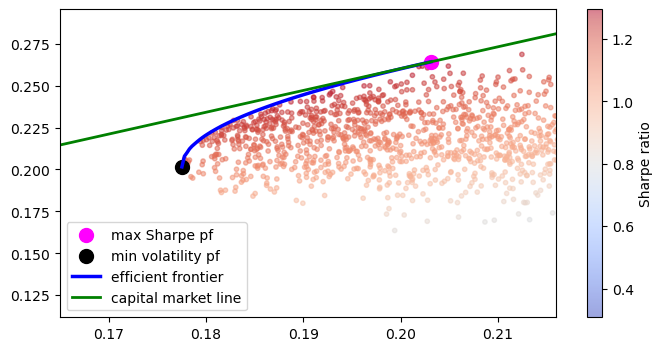

In [7]:
plot_simulation(sim)